# Projeto #1 - Regressão

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/regressor_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 1635078 | Coluna:  29


### Remove os indivíduos não expostos ao risco de morte

In [3]:
df.drop(df[df['estado_fisico'] == 'ileso'].index, inplace=True)
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 498595 | Coluna:  29


### Definição da variável resposta

In [4]:
df['classe'] = df['classificacao_acidente'].map({'com vitimas fatais': 'morto', 
                                                 'com vitimas feridas': 'sobrevivente'
                                                })
round(df['classe'].value_counts(normalize=True)*100, 2)

sobrevivente    91.22
morto            8.78
Name: classe, dtype: float64

### Geração de features

Período da semana

In [5]:
df['periodo_semana'] = df['dia_semana'].map(map_periodo_semana)

Causa presumível do acidente com base nas características

In [6]:
df['causa_presumivel_acidente'] = df['causa_acidente'].apply(mapCausaAcidentes)

Categorização do ano de fabricação do veículo com base na data do acidente

In [7]:
labels = ['ate dez anos', 'mais de dez anos']
classes = [0, 10, 170]

df['tempo_fabricacao_no_ano_do_acidente'] = df['ano'] - df['ano_fabricacao_veiculo']
df['faixa_ano_fabricacao'] = pd.cut(x=df['tempo_fabricacao_no_ano_do_acidente'], bins=classes, labels=labels, include_lowest=True)

Combinação das variáveis tipo de veículo e tipo de envolvido

> Identifica a forma como se deu a participação da vítima no acidente

In [8]:
df['condicao_envolvimento'] = df.apply(lambda x: mapCondicaoEnvolvimento(x.tipo_envolvido, x.porte_veiculo), axis=1)

Agrupamento dos tipos de acidentes

In [9]:
df['tipo_acidente_agrupado'] = df['tipo_acidente'].apply(mapTiposDeAcidentes)

### Seleção de features

In [10]:
colunas = [
    'sexo',
    'faixa_etaria',
    'condicao_envolvimento',
    'tipo_acidente_agrupado',
    'tipo_pista',
    'tracado_via',    
    'periodo_semana',
    'fase_dia',
    'uso_solo',
    'regiao_pais',
    'sentido_via', 
    'condicao_clima',
    'causa_presumivel_acidente',
    'faixa_ano_fabricacao',
    'classe'
]
dados = df[colunas]
dados.head(1)

,sexo,faixa_etaria,condicao_envolvimento,tipo_acidente_agrupado,tipo_pista,tracado_via,periodo_semana,fase_dia,uso_solo,regiao_pais,sentido_via,condicao_clima,causa_presumivel_acidente,faixa_ano_fabricacao,classe
8,masculino,adulto,ocupantes de motocicleta/bicileta,colisão,simples,reta,segunda a quinta-feira,plena noite,urbano,centro-oeste,decrescente,tempo bom,outros aspectos não identificados,ate dez anos,sobrevivente


### Distribuição das variáveis explicativas

In [11]:
for col in dados.columns:
    print(round(dados[col].value_counts(normalize=True)*100, 2))
    print('---------------------------------')

masculino    84.39
feminino     15.61
Name: sexo, dtype: float64
---------------------------------
adulto         56.08
jovem          35.68
idoso           6.23
adolescente     1.21
criança         0.80
Name: faixa_etaria, dtype: float64
---------------------------------
ocupantes de automóveis              43.44
ocupantes de motocicleta/bicileta    41.06
ocupantes de caminhão/ônibus         14.14
pedestre                              1.37
outros veículos                       0.00
Name: condicao_envolvimento, dtype: float64
---------------------------------
colisão                   48.24
saída da pista            20.15
capotamento/tombamento    16.50
queda de veículo           9.84
atropelamento              4.74
outros                     0.54
Name: tipo_acidente_agrupado, dtype: float64
---------------------------------
simples     57.54
dupla       36.62
multipla     5.84
Name: tipo_pista, dtype: float64
---------------------------------
reta                     66.83
curva      

### Regressão logística binomial

> Para todos os testes será empregado o nível de confiança de 95%, ou seja, p-valor < 0.05 indica que os coeficientes estimados foram estatisticamente significativos

Removido os valores que, durante a rodada de testes para seleção do modelo final, tiveram um p-valor > 0.05

In [12]:
dados.drop(dados[dados['fase_dia'] == 'plena noite'].index, inplace=True)
dados.drop(dados[dados['condicao_envolvimento'] == 'outros veículos'].index, inplace=True)
dados.drop(dados[dados['faixa_etaria'] == 'criança'].index, inplace=True)
dados.drop(dados[dados['faixa_etaria'] == 'idoso'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'rotatoria'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'tunel'].index, inplace=True)
dados.drop(dados[dados['tracado_via'] == 'viaduto'].index, inplace=True)
dados.drop(dados[dados['regiao_pais'] == 'norte'].index, inplace=True)
dados.drop(dados[dados['tipo_acidente_agrupado'] == 'outros'].index, inplace=True)
dados.drop(dados[dados['tipo_pista'] == 'multipla'].index, inplace=True)
dados.drop(dados[dados['condicao_envolvimento'] == 'pedestre'].index, inplace=True)

Testando interação entre sexo e idade

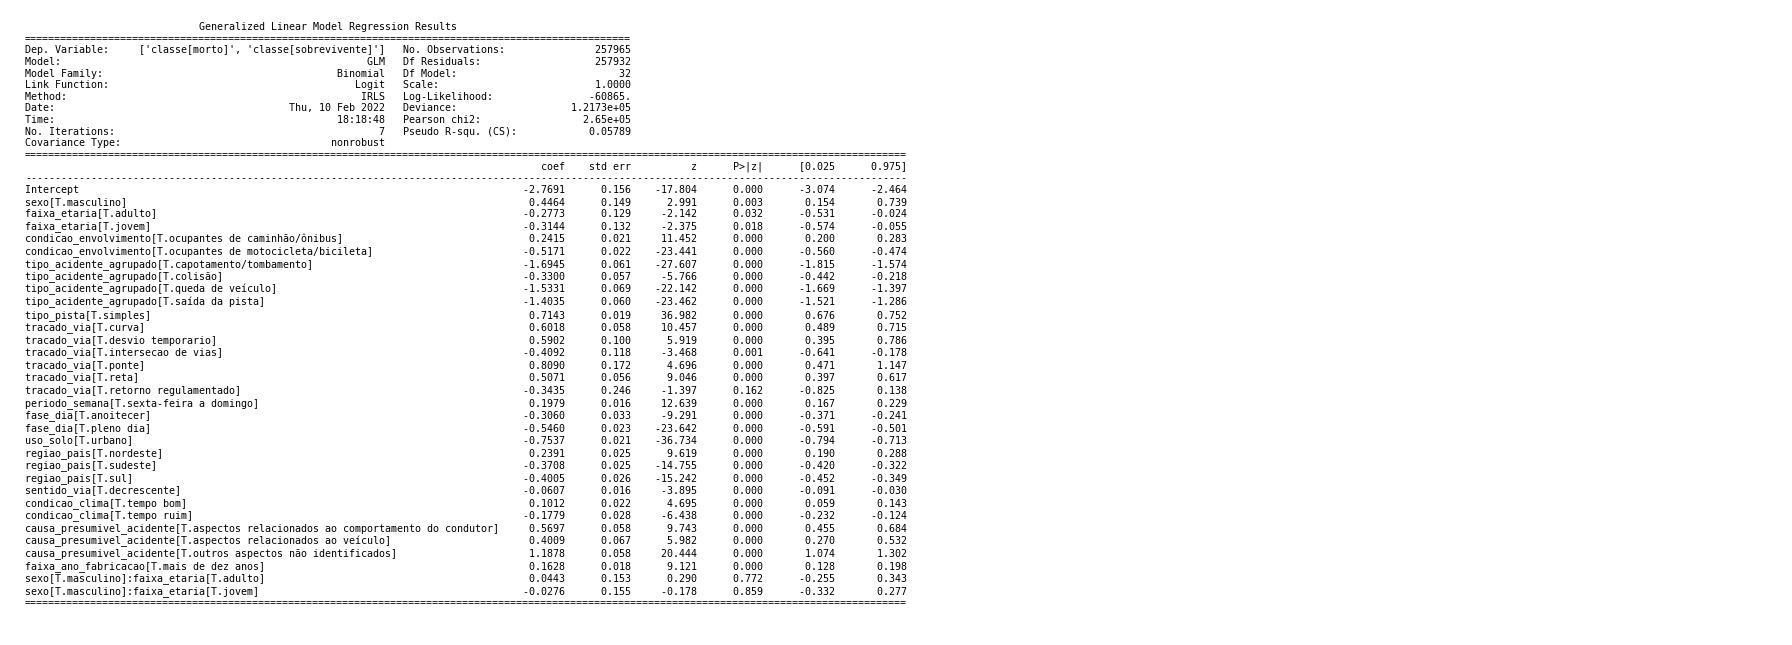

In [13]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+sexo*faixa_etaria', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_sex_age.png')

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que não existe efeito de interação entre as variáveis sexo e idade.<font size=2.85></font></p>

Testando interação entre condição de envolvimento e sexo

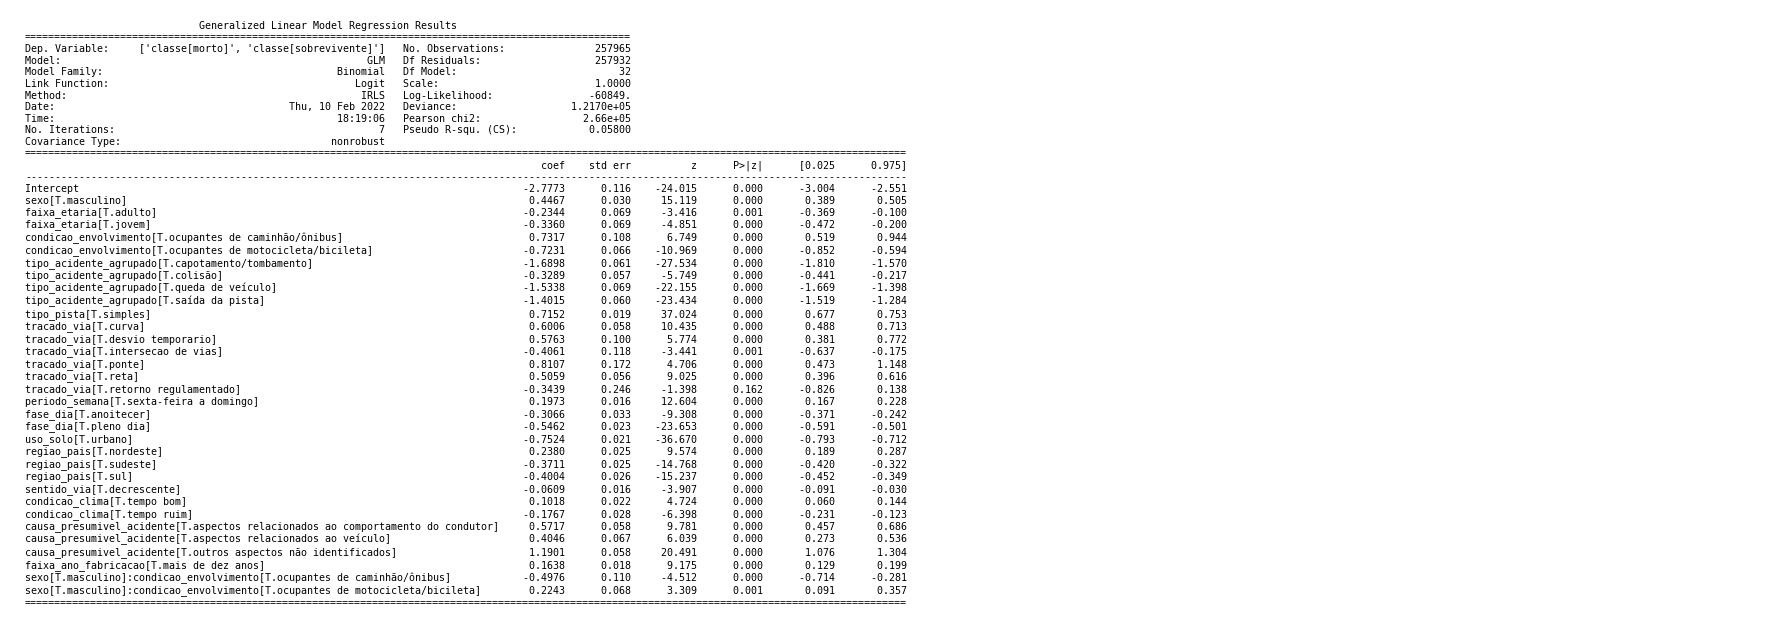

In [14]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+sexo*condicao_envolvimento', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_sexo_envolvimento.png')

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que o efeito de interação entre as variáveis condição de envolvimento e sexo é estatisticamente significativo.</font></p>

Testando interação entre tipo de pista e tipo de acidente

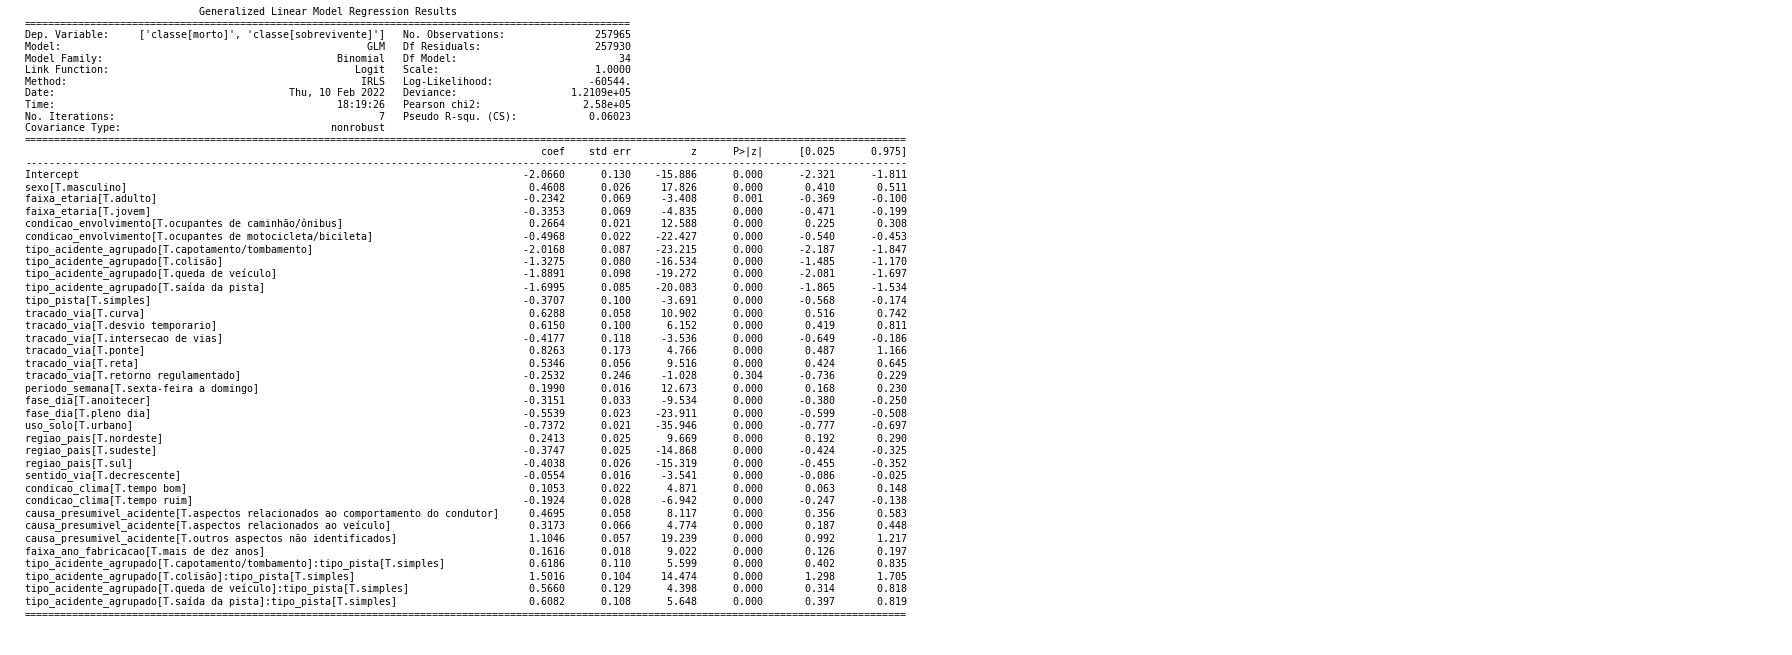

In [15]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+tipo_acidente_agrupado*tipo_pista', 
                 data=dados, family=sm.families.Binomial()).fit()


plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression_interaction_tipo_pista_acidente.png')

> <p style='text-align: justify;'>O p-valor indica que o efeito de interação entre as variáveis tipo de pista e tipo de acidente é estatisticamente significativo.<font size=2.85></font></p>

Modelo final

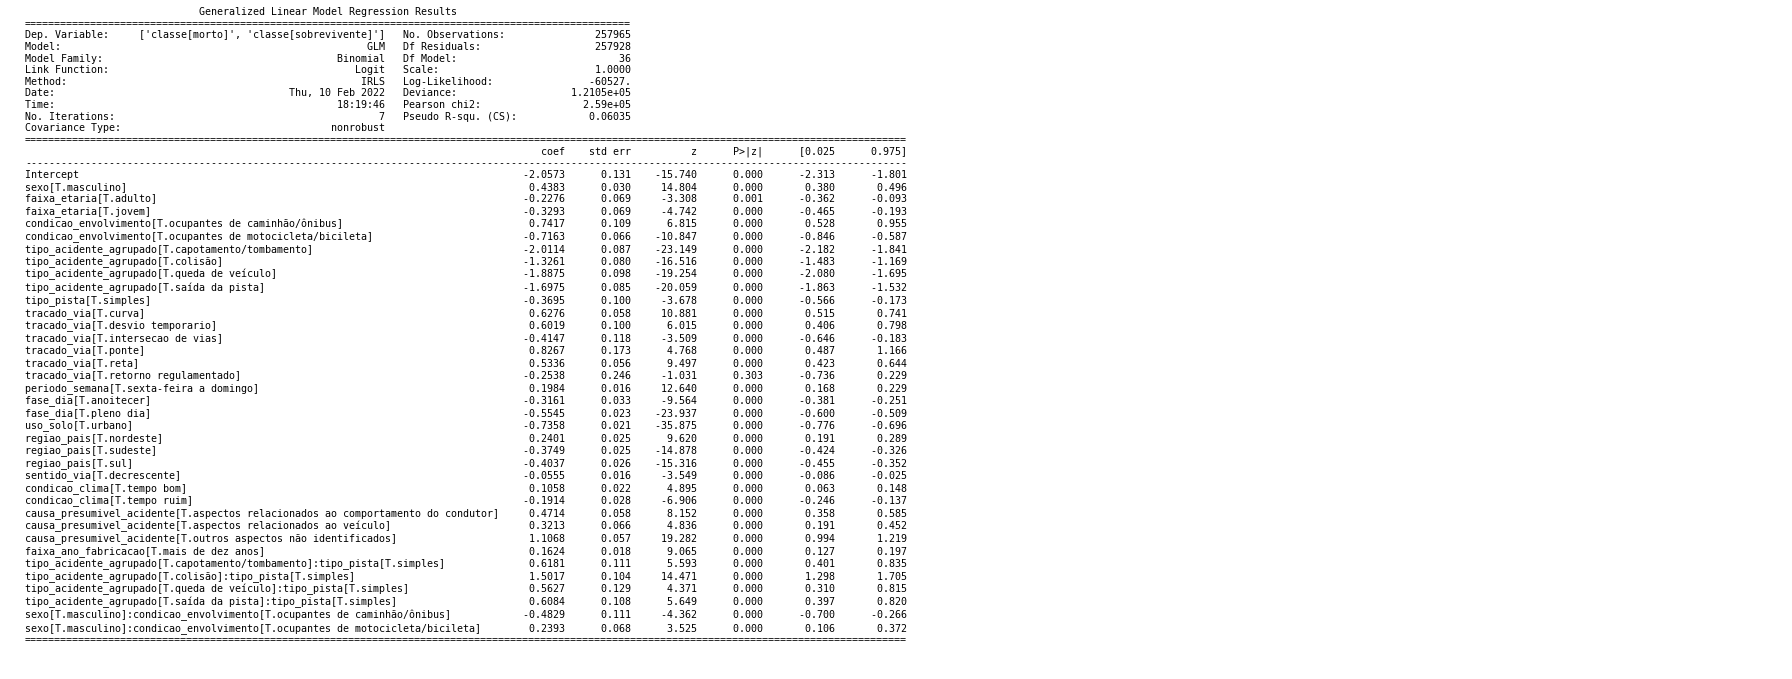

In [16]:
model = smf.glm(formula='classe ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente_agrupado+tipo_pista+tracado_via+periodo_semana+fase_dia+uso_solo+regiao_pais+sentido_via+condicao_clima+causa_presumivel_acidente+faixa_ano_fabricacao+tipo_acidente_agrupado*tipo_pista+sexo*condicao_envolvimento', 
                 data=dados, family=sm.families.Binomial()).fit()

plt.rc('figure', figsize=(25, 10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('img/summary_model_logistic_regression.png')

### Análise da adequação do modelo

In [17]:
X = model.fittedvalues
Y_deviance = model.resid_deviance
Y_person = model.resid_pearson

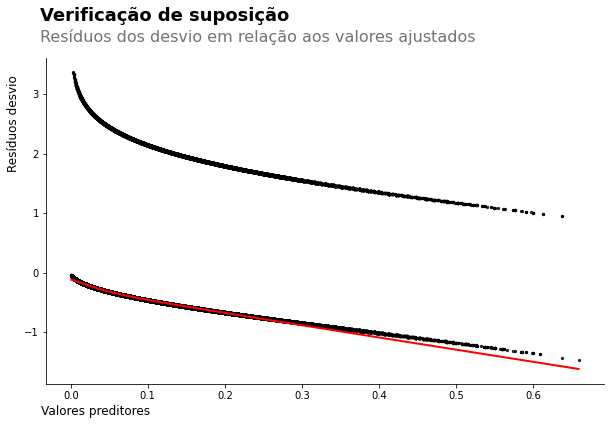

In [18]:
fig, axL = plt.subplots(figsize=(10, 6))
suptitle = 'Verificação de suposição'
title = 'Resíduos dos desvio em relação aos valores ajustados'

sns.regplot(X, 
            Y_deviance, 
            ax= axL, 
            color='black', 
            scatter_kws={'s': 5}, 
            line_kws={'color':'r', 'alpha':1, 'lw':2}, 
            lowess=True)

axL.text(x=-0.01, y=1.10, s=suptitle, color='black', fontsize=18, weight='bold', ha='left', va='bottom', transform=axL.transAxes)
axL.text(x=-0.01, y=1.05, s=title, color='#646464', fontsize=16, alpha=0.9, ha='left', transform=axL.transAxes)
axL.set_xlabel('Valores preditores', fontsize=12, x=0.089)
axL.set_ylabel('Resíduos desvio', fontsize=12, y=0.798)
sns.despine()
plt.grid(False)
plt.show()

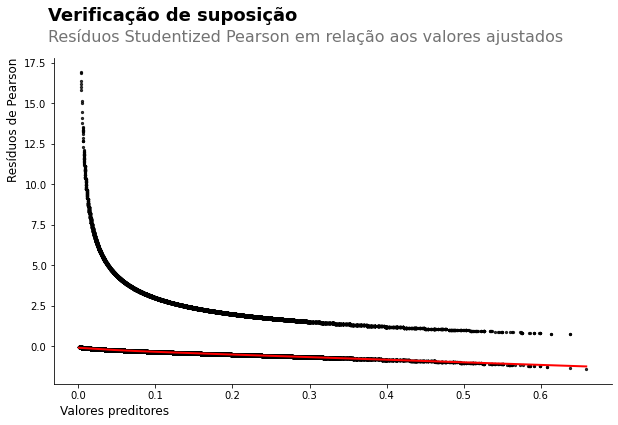

In [19]:
fig, axR = plt.subplots(figsize=(10, 6))
suptitle = 'Verificação de suposição'
title = 'Resíduos Studentized Pearson em relação aos valores ajustados'

sns.regplot(X, 
            Y_person,
            ax= axR,
            color='black', 
            scatter_kws={'s': 5},
            line_kws={'color':'r', 'alpha':1, 'lw':2}, 
            lowess=True)

axR.text(x=-0.01, y=1.10, s=suptitle, color='black', fontsize=18, weight='bold', ha='left', va='bottom', transform=axR.transAxes)
axR.text(x=-0.01, y=1.05, s=title, color='#646464', fontsize=16, alpha=0.9, ha='left', transform=axR.transAxes)
axR.set_xlabel('Valores preditores', fontsize=12, x=0.11)
axR.set_ylabel('Resíduos de Pearson', fontsize=12, y=0.81)
sns.despine()
plt.grid(False)
plt.show()

> <p style='text-align: justify;'>Parece que os gráficos se aproximam da linha horizontal com 0 interceptação, o que sugere que não há inadequação significativa do modelo.<font size=2.85></font></p>

### Teste Qui-quadrado para qualidade do ajustes

> Usado para determinar se uma variável categórica segue ou não uma distribuição hipotética.

In [20]:
import scipy.stats as stats
statistic, pvalue = stats.chisquare(f_obs=X, f_exp=dados['classe'].map({'sobrevivente':0, 'morto': 1}))
print(f'P-valor: {pvalue}')

P-valor: 0.0


### Resultados

In [21]:
print((np.exp(model.params[1:]) - 1) * 100 )

sexo[T.masculino]                                                                   55.009199
faixa_etaria[T.adulto]                                                             -20.357691
faixa_etaria[T.jovem]                                                              -28.054951
condicao_envolvimento[T.ocupantes de caminhão/ônibus]                              109.942840
condicao_envolvimento[T.ocupantes de motocicleta/bicileta]                         -51.143585
tipo_acidente_agrupado[T.capotamento/tombamento]                                   -86.620293
tipo_acidente_agrupado[T.colisão]                                                  -73.448905
tipo_acidente_agrupado[T.queda de veículo]                                         -84.855517
tipo_acidente_agrupado[T.saída da pista]                                           -81.685981
tipo_pista[T.simples]                                                              -30.889814
tracado_via[T.curva]                                        